In [1]:
!pip install captum
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import Lime
from captum.attr import visualization as viz
from captum.attr import Occlusion
from captum.attr import GuidedGradCam
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr import Deconvolution
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution
from captum.attr import GuidedBackprop
from matplotlib.colors import LinearSegmentedColormap

import matplotlib.pyplot as plt 

Defaulting to user installation because normal site-packages is not writeable


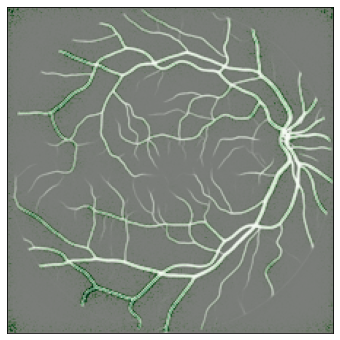

In [13]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    normalize])

trained_model_dir = 'model/VGG16_AutoMorph_TESTFOLD_1_6180_1300.pth'
test_batch_size = 1

model = models.vgg16()
model.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
checkpoint = torch.load(trained_model_dir)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda()
model = model.eval()

img = 'all_data/vessel/C/5797997_21016_0_0.png'
img = plt.imread(img)
original_image = np.transpose(img, (2,0,1))
original_image = torch.from_numpy(original_image)
transformed_img = test_transform(original_image).unsqueeze(dim = 0).cuda()


# The transformed image has shape (1,3,224,224)
output = model(transformed_img)
prediction_scores = F.softmax(output, dim = 1)
class_prediction = torch.argmax(prediction_scores, dim = 1)

#print(prediction_scores)
#if class_prediction.item() == 1:
#    print('PREDICTION: AD')
#else:
#    print('PREDICTION: NC')

#saliency = NoiseTunnel(Saliency(model))
#saliency = Saliency(model)
#attributions_saliency = saliency.attribute(transformed_img, nt_samples = 10, target = 1)

saliency = NoiseTunnel(GuidedBackprop(model))
attributions_saliency = saliency.attribute(transformed_img, nt_samples = 10, target = 1)

#attributions_ig = ig.attribute(transformed_img, target = 1)
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_saliency.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method= "blended_heat_map",
                             cmap= "Greens",
                             show_colorbar= False,
                            fig_size = (6,6))
#plt.savefig('CLUSTER_A_GBP.pdf')



In [206]:
print(original_image.shape)

torch.Size([3, 224, 224])


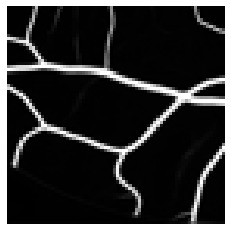

In [11]:
from math import floor
attribution_map = attributions_saliency
size_kernel = 70
sliding_window = torch.ones(1, 3, size_kernel, size_kernel).cuda()
output = F.conv2d(attribution_map, sliding_window).cpu().detach().numpy().squeeze()

def max_crop_from_output(convolved_array: np.ndarray, 
                         orig_array: np.ndarray, 
                         original_image: np.ndarray,
                         crop_size: int) -> np.ndarray:
    """
        Takes in convolved array, the original input array cropped centered at the max value
    """
    mdpt_conv_x = floor(convolved_array.shape[0] / 2)  
    mdpt_conv_y = floor(convolved_array.shape[1] / 2)  
    mdpt_x = floor(orig_array.shape[1] / 2)
    mdpt_y = floor(orig_array.shape[2] / 2)
    max_x, max_y = np.unravel_index(np.argmax(np.abs(convolved_array), axis=None), convolved_array.shape)
    crop_x = max_x - mdpt_conv_x + mdpt_x
    crop_y = max_y - mdpt_conv_y + mdpt_y
    crop_x_range = [crop_x - crop_size, crop_x + crop_size]
    crop_y_range = [crop_y - crop_size, crop_y + crop_size]
    cropped_input = orig_array[:, 
                               crop_x_range[0]:crop_x_range[1], 
                               crop_y_range[0]:crop_y_range[1]]
    cropped_original_image = original_image[:, 
                                            crop_x_range[0]:crop_x_range[1], 
                                            crop_y_range[0]:crop_y_range[1]]
    #print(crop_x_range, crop_y_range)
    
    
    return cropped_input, cropped_original_image, crop_x_range, crop_y_range
cropped_input, cropped_original_image, crop_x_range, crop_y_range = max_crop_from_output(output.squeeze(),
                                     attribution_map.squeeze().cpu().detach().numpy(),
                                    original_image.cpu().detach().numpy(),
                                    crop_size = int(size_kernel / 2))

plt.axis('off')
plt.savefig('CLUSTER_A_GBP_CROPPED.png', format = "png")
plt.imshow(np.transpose(cropped_original_image, (1,2,0)), cmap = 'gray')
plt.show()

#plt.imshow(np.transpose(original_image, (1,2,0)))

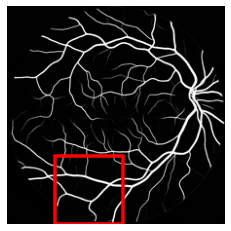

In [12]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
plt.axis('off')
ax.imshow(np.transpose(original_image, (1,2,0)))
midpoint_x = (crop_x_range[1] - crop_x_range[0])/2

midpoint_y = (crop_y_range[1] - crop_y_range[0]) / 2


rect = patches.Rectangle((crop_y_range[0], crop_x_range[0]), # the coordinates of the bottom anchor 
                         crop_y_range[1] - crop_y_range[0], 
                         crop_x_range[1] - crop_x_range[0] , linewidth = 3.5, edgecolor = 'r', facecolor = 'none')
ax.add_patch(rect)

plt.savefig('CLUSTER_A_GBP_BOX.png')
plt.show()


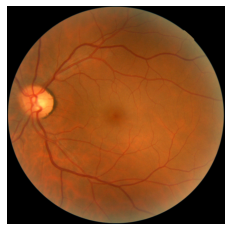

In [15]:
A = 'all_data/fundus/A/58_1945494_21015_0_0.png'
plt.axis('off')
plt.imshow(plt.imread(A))

In [11]:
import os 
import shutil
cluster_A = ['58_1945494_21015_0_0',
'58_1965046_21015_0_0',
'60_2005891_21015_1_0',
'63_1967731_21015_0_0',
'64_1992837_21015_0_0',
'64_2054504_21015_0_0',
'65_2044299_21015_0_0',
'67_2211709_21015_0_0',
'67_2225035_21015_0_0',
'58_1949649_21015_0_0',
'62_1944807_21015_0_0',
'63_1966316_21015_0_0',
'67_2270204_21015_0_0',
'68_2070939_21015_0_0',
'68_2090811_21015_1_0',
'69_2246795_21015_0_0',
'56_1967513_21015_1_0',
'62_1949741_21015_0_0',
'62_1956515_21015_0_0',
'63_1991515_21015_0_0',
'64_1999182_21015_0_0',
'64_2006937_21015_0_0',
'65_2069614_21015_0_0',
'67_2090269_21015_0_0',
'68_2086545_21015_0_0',
'55_1955339_21015_0_0',
'59_1956683_21015_0_0',
'63_1980899_21015_0_0',
'64_2022296_21015_0_0',
'67_2092474_21015_1_0',
'67_2178809_21015_0_0',
'58_1998146_21015_0_0',
'59_1937872_21015_0_0',
'62_1940976_21015_0_0',
'62_1950639_21015_1_0',
'65_2072002_21015_0_0',
'66_2034796_21015_0_0',
'67_2124038_21015_0_0',
'67_2213123_21015_0_0']

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_A:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/60_2005891_21015_1_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/58_1945494_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/67_2211709_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/64_2054504_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/64_1992837_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/65_2044299_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/67_2225035_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/58_1965046_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization

In [15]:
cluster_B = ['58_1967292_21015_1_0',
'65_2047029_21015_0_0',
'69_2173894_21015_0_0',
'69_2401125_21015_0_0',
'1717637_21015_0_0',
'1798978_21015_0_0',
'2752105_21015_0_0',
'3663301_21015_0_0',
'4168187_21015_0_0',
'5797997_21015_0_0',
'58_1966584_21015_1_0',
'64_2012028_21015_0_0',
'64_2037416_21015_0_0',
'65_1935917_21015_0_0',
'66_2032128_21015_0_0',
'67_2077735_21015_0_0',
'69_2386992_21015_0_0',
'2140246_21015_0_0',
'2528238_21015_0_0',
'3193871_21015_1_0',
'4632627_21015_0_0',
'5996465_21015_0_0',
'64_2041474_21015_0_0',
'66_2026376_21015_0_0',
'67_2084033_21015_0_0',
'67_2221251_21015_0_0',
'69_2105218_21015_1_0',
'69_2215237_21015_0_0',
'69_2441560_21015_0_0',
'1981617_21015_0_0',
'2854049_21015_0_0',
'3156519_21015_0_0',
'3996413_21015_0_0',
'5417838_21015_0_0',
'5671070_21015_0_0',
'5805701_21015_0_0',
'5807004_21015_1_0',
'60_1929611_21015_0_0',
'62_1940919_21015_0_0',
'64_2014228_21015_0_0',
'65_2010673_21015_0_0',
'66_2029072_21015_0_0',
'68_2108442_21015_0_0',
'69_2324115_21015_0_0',
'1373741_21015_0_0',
'2737210_21015_0_0',
'4668921_21015_0_0',
'5786592_21015_0_0',
'63_1971450_21015_0_0',
'64_2033373_21015_1_0',
'66_2006299_21015_0_0',
'67_2122596_21015_0_0',
'69_2210947_21015_0_0',
'69_2224594_21015_0_0',
'1069445_21015_0_0',
'1218253_21015_0_0',
'1241632_21015_1_0',
'3038124_21015_0_0',
'3542983_21015_1_0',
'4817577_21015_0_0',
'4840333_21015_0_0',
'5724508_21015_0_0'] 

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_B:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)
        

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/2752105_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/65_2047029_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/69_2173894_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/1717637_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/3663301_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/58_1967292_21015_1_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/69_2401125_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/4168187_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/ve

In [16]:
cluster_C = ['1717637_21016_0_0',
'1798978_21016_0_0',
'2874133_21015_0_0',
'2874133_21016_0_0',
'5797997_21016_0_0',
'2331301_21016_0_0',
'4025604_21015_0_0',
'4025604_21016_0_0',
'4859498_21015_0_0',
'2854049_21016_0_0',
'5417838_21016_0_0',
'1373741_21016_0_0',
'1857171_21015_0_0',
'1857171_21016_0_0',
'2064624_21016_0_0',
'2106574_21015_0_0',
'2106574_21016_0_0',
'4668921_21016_0_0',
'5786592_21016_0_0',
'3038124_21016_0_0',
'4817577_21016_0_0']

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_C:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)
        

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/1798978_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/2874133_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/1717637_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/5797997_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/2874133_21016_0_0.png


In [18]:
cluster_D = ['60_1015022_21016_1_0',
'64_2040519_21015_0_0',
'64_2040519_21016_0_0',
'67_1008965_21016_0_0',
'64_2037416_21016_0_0',
'65_1031083_21016_0_0',
'67_2077735_21016_0_0',
'68_2070939_21016_0_0',
'66_1039195_21016_0_0',
'66_2029072_21016_0_0',
'68_1035901_21016_0_0',
'69_2324115_21016_0_0',
'65_1030019_21016_0_0',
'66_2006299_21016_0_0',
'67_2124038_21016_0_0'
]

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_D:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/60_1015022_21016_1_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/64_2040519_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/67_1008965_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/64_2040519_21015_0_0.png


In [20]:
cluster_E = ['1081429_21015_0_0',
'2133865_21016_0_0',
'2568612_21015_0_0',
'2752105_21016_0_0',
'2140246_21016_0_0',
'4632627_21016_0_0',
'4962761_21016_0_0',
'5996465_21016_0_0',
'2861613_21016_0_0',
'4544580_21016_1_0',
'4677188_21015_0_0',
'1585185_21016_0_0',
'2737210_21016_0_0',
'3511985_21015_0_0',
'4248640_21016_0_0',
'5561169_21015_0_0',
'5561169_21016_0_0',
'5264571_21015_0_0']

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_E:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/2133865_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/1081429_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/2752105_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/2568612_21015_0_0.png


In [23]:
cluster_F = ['1618105_21016_0_0',
'2568612_21016_0_0',
'3663301_21016_0_0',
'3867860_21016_1_0',
'4088581_21016_0_0',
'2331301_21015_0_0',
'2528238_21016_0_0',
'2590563_21016_0_0',
'2785148_21016_0_0',
'3193871_21016_1_0',
'4780479_21016_0_0',
'4859498_21016_0_0',
'1981617_21016_0_0',
'3156519_21016_0_0',
'3996413_21016_0_0',
'5671070_21016_0_0',
'5805701_21016_0_0',
'5807004_21016_1_0',
'5809818_21016_0_0',
'3511985_21016_0_0',
'5302076_21016_0_0',
'1069445_21016_0_0',
'1218253_21016_0_0',
'1241632_21016_1_0',
'2665899_21016_0_0',
'4111242_21016_1_0',
'4782434_21016_0_0',
'4840333_21016_0_0',
'5264571_21016_0_0',
'5724508_21016_0_0'
]

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_F:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/4088581_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/3663301_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/3867860_21016_1_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/2568612_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/1618105_21016_0_0.png


In [25]:
cluster_G = ['60_2005891_21016_1_0',
'65_2044299_21016_0_0',
'67_2211709_21016_0_0',
'64_2012028_21016_0_0',
'66_1055263_21016_0_0',
'56_1967513_21016_1_0',
'65_2069614_21016_0_0',
'66_2026376_21016_0_0',
'67_2090269_21016_0_0',
'55_1955339_21016_0_0',
'60_1929611_21016_0_0',
'60_1987964_21016_0_0',
'64_1009907_21016_0_0',
'66_2034796_21016_0_0',
'67_2213123_21016_0_0'
]

vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/'
output_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/'
os.makedirs(output_dir, exist_ok = True)
for img in os.listdir(vessel_dir):
    if str(img[:-4]) in cluster_G:
        shutil.copy(vessel_dir + img,  output_dir + img)
        print('SAVED IMAGE:', output_dir + img)

SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/67_2211709_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/65_2044299_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/60_2005891_21016_1_0.png


In [36]:
input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/C/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/D/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/E/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################


input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/F/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/AD_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/G/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################



SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/2752105_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/1717637_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/3663301_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/4168187_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/5797997_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/1798978_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/C/1798978_21016_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/C/2874133_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/C/17176

In [37]:
input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/A/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/B/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/B/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/C/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/C/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/D/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/D/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/E/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/E/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################


input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/F/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/F/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################

input_fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/AutoMorph/CN_RESULTS_61/M0/images/'
vessel_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/vessel/G/'
fundus_dir = '/blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/G/'
os.makedirs(fundus_dir, exist_ok = True)

for img in os.listdir(input_fundus_dir):
    if str(img) in os.listdir(vessel_dir):
        shutil.copy(input_fundus_dir + img, fundus_dir + img)
        print('SAVED IMAGE:', fundus_dir + img)

#################################################################################################
#################################################################################################
#################################################################################################



SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/60_2005891_21015_1_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/58_1945494_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/67_2211709_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/64_2054504_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/64_1992837_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/65_2044299_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/67_2225035_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization/all_data/fundus/A/58_1965046_21015_0_0.png
SAVED IMAGE: /blue/ruogu.fang/charlietran/UKB/code/Feature_visualization